In [1]:
pip install torch torchvision opencv-python matplotlib tqdm


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import json
import os
import numpy as np
from torchvision.ops import masks_to_boxes
import cv2

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations = json.load(open(annotation_file))
        self.height = self.annotations['images'][0]['height']
        self.width = self.annotations['images'][0]['width']
        self.to_tensor = T.ToTensor()  # Convert PIL image to tensor

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_id = self.annotations['images'][idx]['id']
        img_path = os.path.join(self.root, self.annotations['images'][idx]['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Convert image to tensor
        image = self.to_tensor(image)

        # Get annotation for this image
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == img_id]

        boxes, masks, labels = [], [], []
        for ann in annotations:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

            # Convert segmentation polygons to binary masks
            mask = torch.zeros((self.height, self.width), dtype=torch.uint8)  # Empty mask
            for seg in ann['segmentation']:  # Segmentation can have multiple polygons
                poly = np.array(seg, dtype=np.int32).reshape(-1, 2)  # Convert to (N,2)
                mask = self.draw_polygon(mask, poly)  # Draw polygon mask

            masks.append(mask)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks) if masks else torch.zeros((0, self.height, self.width), dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

    def draw_polygon(self, mask, poly):
        """Draws a polygon on a binary mask."""
        cv2.fillPoly(mask.numpy(), [poly], 1)
        return mask


In [2]:
# !pip install torchvision
# 

In [3]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

num_classes = 14  # 13 classes + background

# Load pre-trained Mask R-CNN
model = maskrcnn_resnet50_fpn(pretrained=True)

# Modify classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Modify mask head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)


/home/aiunika/Desktop/180_resnet/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aiunika/Desktop/180_resnet/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Resnet')
# print(os.getcwd())  # Verify the new working directory

# # List files
# files = os.listdir()
# print("Files in My Drive:\n", files)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import tqdm
from tqdm import tqdm  # Progress bar

# Define train and validation datasets
train_dataset = CustomDataset(root="/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/train",
                              annotation_file="/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/train/_annotations.coco.json")
val_dataset = CustomDataset(root="/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/valid",
                            annotation_file="/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/valid/_annotations.coco.json")
print('Dataloader initialized')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
print('Dataloader ready')

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

best_val_loss = float("inf")
print('Training started')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    total_train_loss = 0

    # Using tqdm for progress bar in training
    train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Batches", ncols=100)

    for batch_idx, (images, targets) in train_progress:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

        # Update progress bar
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # In GB
            reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)  # In GB
            train_progress.set_postfix({
                "Loss": f"{losses.item():.4f}",
                "GPU Allocated": f"{allocated:.2f} GB",
                "GPU Reserved": f"{reserved:.2f} GB"
            })

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode (correct)
    total_val_loss = 0

    val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Batches", ncols=100)

    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_idx, (images, targets) in val_progress:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # No need to call model.train() here
            loss_dict = model(images, targets)

            if isinstance(loss_dict, list):  # If predictions are returned instead of losses
                print("Warning: Model returned predictions instead of losses during validation.")
                continue

            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()

            # Update progress bar with memory info (if CUDA is available)
            if torch.cuda.is_available():
                allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # In GB
                reserved = torch.cuda.memory_reserved(device) / (1024 ** 3)  # In GB
                val_progress.set_postfix({
                    "Loss": f"{losses.item():.4f}",
                    "GPU Allocated": f"{allocated:.2f} GB",
                    "GPU Reserved": f"{reserved:.2f} GB"
                })

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_mask_rcnn.pth")
        print("Saved best model!")

# Save final model
torch.save(model.state_dict(), "final_mask_rcnn.pth")


Dataloader initialized
Dataloader ready
Training started

Epoch 1/20


Training Batches: 100%|█| 608/608 [03:36<00:00,  2.80it/s, Loss=0.4622, GPU Allocated=1.03 GB, GPU R
Validation Batches: 100%|█| 99/99 [00:15<00:00,  6.45it/s, Loss=0.4607, GPU Allocated=0.73 GB, GPU R


Epoch 1 | Train Loss: 0.5079 | Val Loss: 0.6016
Saved best model!

Epoch 2/20


Training Batches: 100%|█| 608/608 [03:37<00:00,  2.79it/s, Loss=0.3424, GPU Allocated=0.98 GB, GPU R
Validation Batches: 100%|█| 99/99 [00:16<00:00,  6.15it/s, Loss=0.4216, GPU Allocated=0.73 GB, GPU R


Epoch 2 | Train Loss: 0.3968 | Val Loss: 0.6092

Epoch 3/20


Training Batches: 100%|█| 608/608 [03:30<00:00,  2.88it/s, Loss=0.4226, GPU Allocated=1.07 GB, GPU R
Validation Batches: 100%|█| 99/99 [00:16<00:00,  6.18it/s, Loss=0.4480, GPU Allocated=0.73 GB, GPU R


Epoch 3 | Train Loss: 0.3571 | Val Loss: 0.5724
Saved best model!

Epoch 4/20


Training Batches: 100%|█| 608/608 [03:27<00:00,  2.93it/s, Loss=0.3445, GPU Allocated=1.04 GB, GPU R
Validation Batches: 100%|█| 99/99 [00:14<00:00,  6.87it/s, Loss=0.3796, GPU Allocated=0.73 GB, GPU R


Epoch 4 | Train Loss: 0.3284 | Val Loss: 0.6156

Epoch 5/20


Training Batches: 100%|█| 608/608 [03:30<00:00,  2.89it/s, Loss=0.2593, GPU Allocated=0.90 GB, GPU R
Validation Batches: 100%|█| 99/99 [00:14<00:00,  6.83it/s, Loss=0.4474, GPU Allocated=0.73 GB, GPU R


Epoch 5 | Train Loss: 0.2995 | Val Loss: 0.6893

Epoch 6/20


Training Batches:  38%|▍| 229/608 [01:18<02:29,  2.54it/s, Loss=0.2754, GPU Allocated=1.21 GB, GPU R

In [7]:
import torch
torch.cuda.empty_cache()


In [25]:
# from google.colab import auth
# auth.authenticate_user()

# from google.colab import files
# files.view()


MessageError: Error: credential propagation was unsuccessful

In [21]:
import torch
import torchvision

# Define the number of classes (including background)
num_classes = 14  # Change this to match the number of classes in your dataset

# Load Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

# Modify the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Modify the mask head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Load trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/Resnet/best_mask_rcnn.pth", map_location=torch.device("cpu")))

# Set model to evaluation mode
model.eval()



MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

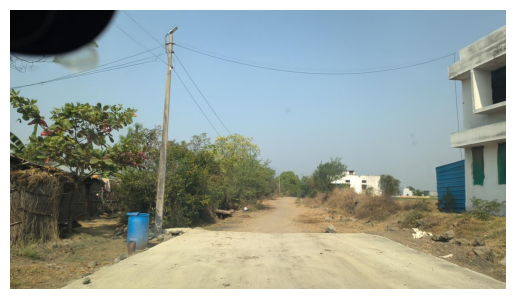

In [ ]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Load image
image_path = "/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/train/2024116_142944_123_jpg.rf.a955d1e50f9e0fed69e2ee03f4509b55.jpg"  # Change to your image path
image = Image.open(image_path).convert("RGB")

# Convert to tensor
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Run inference
with torch.no_grad():
    predictions = model(image_tensor)

# Show the image
plt.imshow(image)
plt.axis("off")
plt.show()

